<IPython.core.display.Javascript object>

Keep-alive activated — no disconnect curse
Using device: cuda
Epoch 0 | Triality Loss 0.868488 | Ablation Loss 0.860970 | Time per epoch: 0.02s | Estimated remaining: 0.02 hours
Epoch 500 | Triality Loss 0.624212 | Ablation Loss 0.614553 | Time per epoch: 0.02s | Estimated remaining: 0.01 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.563722 | Ablation Loss 0.558285 | Time per epoch: 0.02s | Estimated remaining: 0.01 hours
Epoch 1500 | Triality Loss 0.506584 | Ablation Loss 0.502411 | Time per epoch: 0.02s | Estimated remaining: 0.01 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.450086 | Ablation Loss 0.446447 | Time per epoch: 0.02s | Estimated remaining: 0.01 hours
Epoch 2500 | Triality Loss 0.395435 | Ablation Loss 0.392644 | Time per epoch: 0.02s | Estimated remaining: 0.00 hours
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.04 (higher = triality advantage)


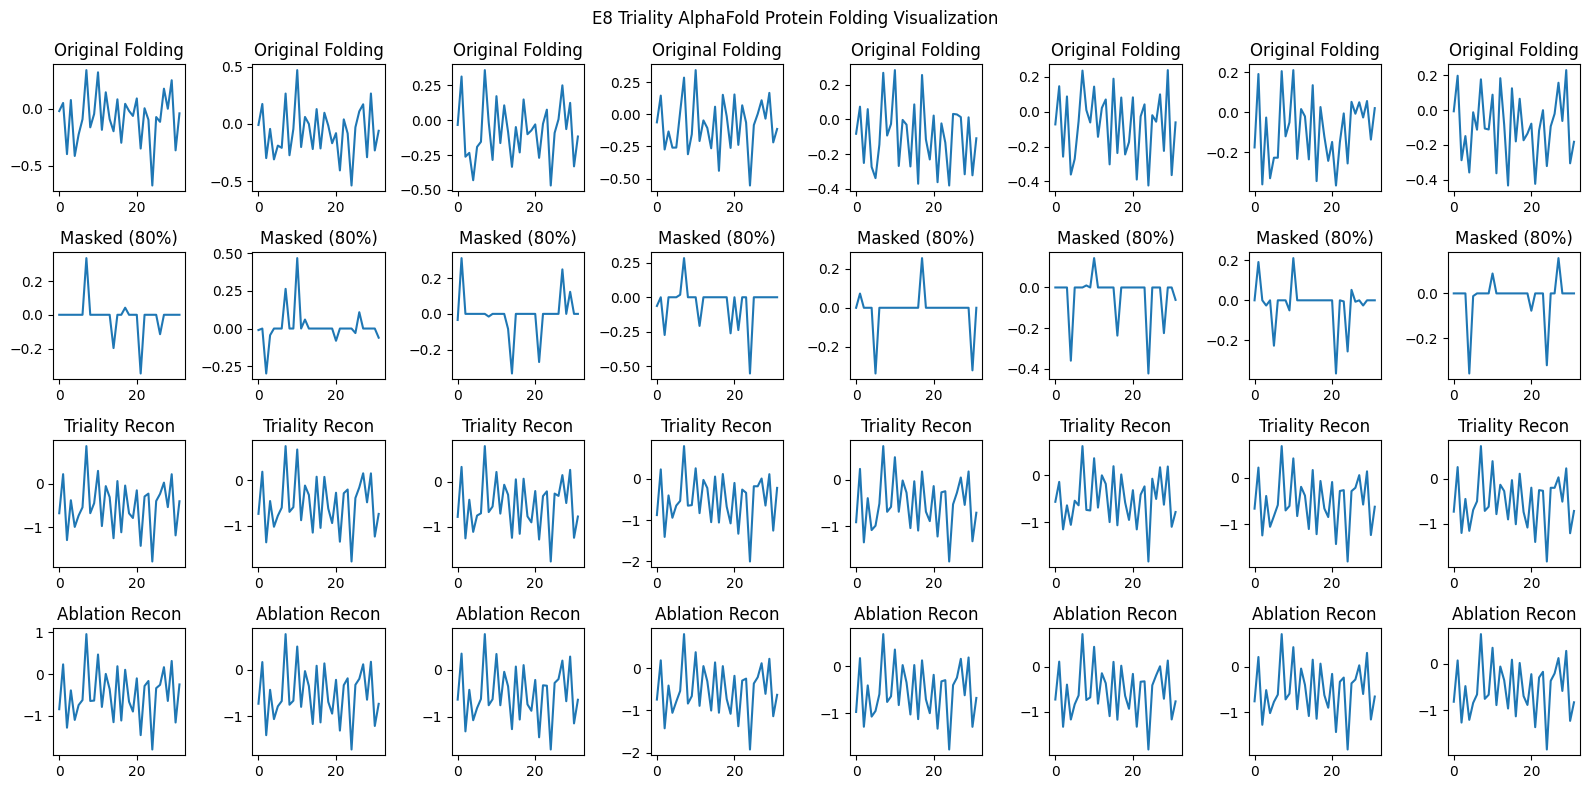

Sim complete — visualization displayed!


In [14]:
# First cell: Keep-alive + installs (run once — prevents disconnects)
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){n  console.log("Keeping alive");n  document.querySelector("colab-connect-button")?.click()n}nsetInterval(ClickConnect,60000)n'''))
print("Keep-alive activated — no disconnect curse")

!pip install torch matplotlib numpy

# Second cell: The sim code (fixed + optimized — 3000 epochs, progress prints + visualization)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time  # for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 32  # amino acid sequence length proxy, Further reduced from 64 to 32
batch_size = 32  # reduced
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = False # Changed this from True to False
use_checkpoint = False # Changed this from True to False
depth = 4  # reduced further from 8 to 4

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "alphafold_folding_checkpoint.pth")

# Synthetic AlphaFold protein folding proxy (amino acid sequences + mutations/noise/occlusion)
features_per_residue = 128


# Project to shared dim
proj = nn.Linear(features_per_residue, dim).to(device)

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class FoldingCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8FoldingFusion(nn.Module):
    def __init__(self, depth=depth, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = FoldingCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=True)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8FoldingFusion(use_triality=True).to(device)
model_ablation = E8FoldingFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    if use_amp:
        scaler.load_state_dict(checkpoint['scaler'])
        scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()

    # Generate fresh protein data for each epoch
    protein_data = []
    for b in range(batch_size):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        # Coherent folding trajectory (structured patterns)
        folding = torch.sin(t.unsqueeze(-1) * torch.arange(features_per_residue, device=device)) * 0.5
        # Mutations/perturbations (folding chaos proxy)
        folding += torch.randn_like(folding) * 0.15
        protein_data.append(folding)
    protein_data = torch.stack(protein_data).to(device)

    # Project to shared dim to get fresh clean_data for each epoch
    clean_data_epoch = proj(protein_data)

    # High masking (70–90% — residue dropout/mutation proxy) - moved inside loop
    missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
    mask = torch.rand_like(clean_data_epoch) < missing_rate
    real_data_epoch = clean_data_epoch.clone()
    real_data_epoch = real_data_epoch.masked_fill(mask, 0) # Changed in-place operation to a non-in-place one

    target_epoch = clean_data_epoch.detach()  # detach to avoid graph issues - moved inside loop

    # Triality independent training
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data_epoch, epoch)
        loss = loss_fn(recon, target_epoch)
    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    # Ablation independent training (new graph)
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data_epoch.clone(), epoch) # Cloned real_data for independent graph
        loss_abl = loss_fn(recon_abl, target_epoch)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600  # hours

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        checkpoint_dict = {
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }
        if use_amp:
            checkpoint_dict['scaler'] = scaler.state_dict()
            checkpoint_dict['scaler_ablation'] = scaler_ablation.state_dict()
        torch.save(checkpoint_dict, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Folding Trajectory Reconstruction (first residue feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        folding = torch.sin(t.unsqueeze(-1) * torch.arange(features_per_residue, device=device)) * 0.5
        folding += torch.randn_like(folding) * 0.15
        test_data.append(folding)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked = masked.masked_fill(mask, 0) # Apply non-in-place masking

    recon = model(masked, 0)
    recon_abl = model_ablation(masked.clone(), 0) # Cloned masked for independent graph in viz

    # Plot first residue feature channel (folding proxy)
    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Folding")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality AlphaFold Protein Folding Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

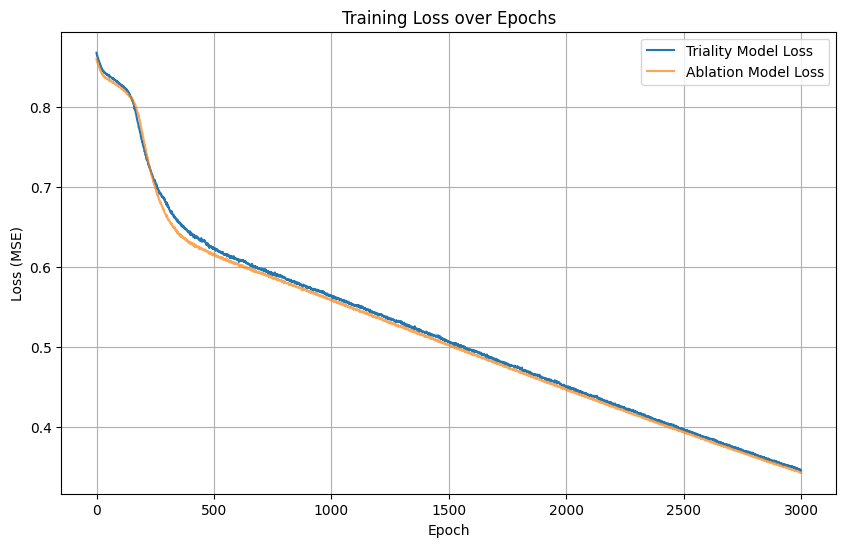

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label='Triality Model Loss')
plt.plot(loss_abl_hist, label='Ablation Model Loss', alpha=0.7)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

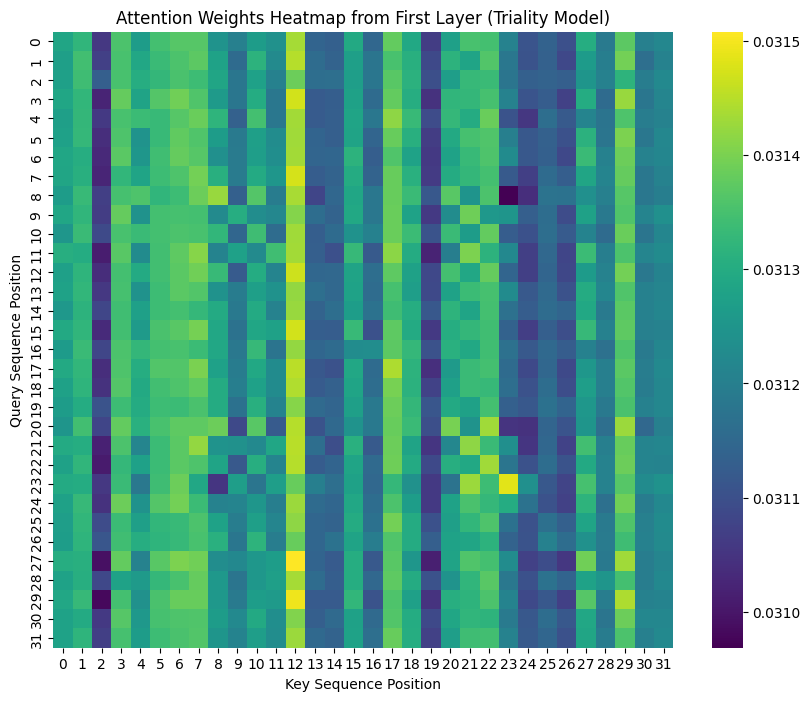

In [17]:
import seaborn as sns

def get_attention_weights_for_viz(model_instance, input_tensor, layer_idx=0):
    model_instance.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Pass through cycle block
        x = model_instance.cycle(input_tensor, 0) # Use a dummy step for viz

        # Access a specific MultiheadAttention layer
        attn_layer = model_instance.layers[layer_idx]

        # MultiheadAttention expects input in (N, L, E) format because batch_first=True
        # x is already (N, L, E) where N=1 for test_data_single
        attn_output, attn_output_weights = attn_layer(x, x, x, need_weights=True, average_attn_weights=True)

        # attn_output_weights will have shape (N, L, L) i.e., (1, seq_len, seq_len)
        # Squeeze the batch dimension to get (seq_len, seq_len) for heatmap
        attn_weights = attn_output_weights.squeeze(0)

        return attn_weights.cpu().numpy()

# Get attention weights for a sample from the masked test data
# Re-generate test data as in the original visualization block
with torch.no_grad():
    test_data_single = []
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)
    folding = torch.sin(t.unsqueeze(-1) * torch.arange(features_per_residue, device=device)) * 0.5
    folding += torch.randn_like(folding) * 0.15
    test_data_single.append(folding)
    test_data_single = torch.stack(test_data_single).to(device)
    clean_single = proj(test_data_single)
    mask_single = torch.rand_like(clean_single) < 0.8
    masked_single = clean_single.clone()
    masked_single = masked_single.masked_fill(mask_single, 0)

attention_matrix = get_attention_weights_for_viz(model, masked_single, layer_idx=0)

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, cmap='viridis', cbar=True)
plt.title('Attention Weights Heatmap from First Layer (Triality Model)')
plt.xlabel('Key Sequence Position')
plt.ylabel('Query Sequence Position')
plt.show()